# 4개 모델 성능 비교(통합데이터)
```
    Model         Accuracy Flood Recall  ROC AUC
RandomForest        0.980      0.850      0.970
XGBoost             0.964      0.876      0.977
LSTM+CNN            0.587      0.000      0.769
Transformer+SMOTE   0.740      0.910      0.874

최고의 모델은 RANDOMFOREST(통합)
Transformer+SMOTE는 침수 Recall과 AUC에서 강점을 보이며, 실사용 시 "침수 탐지"가 핵심이라면 매우 효과적

해석 요약 테이블
     모델          Accuracy   Recall    ROC AUC    Precision    F1-score
RandomForest        0.980      0.850     0.970       0.960        0.920
XGBoost             0.964      0.876     0.977       0.816        0.845
LSTM+CNN            0.587      0.000     0.769       0.196        0.320
Transformer+SMOTE   0.740      0.910     0.874       0.290        0.440
```

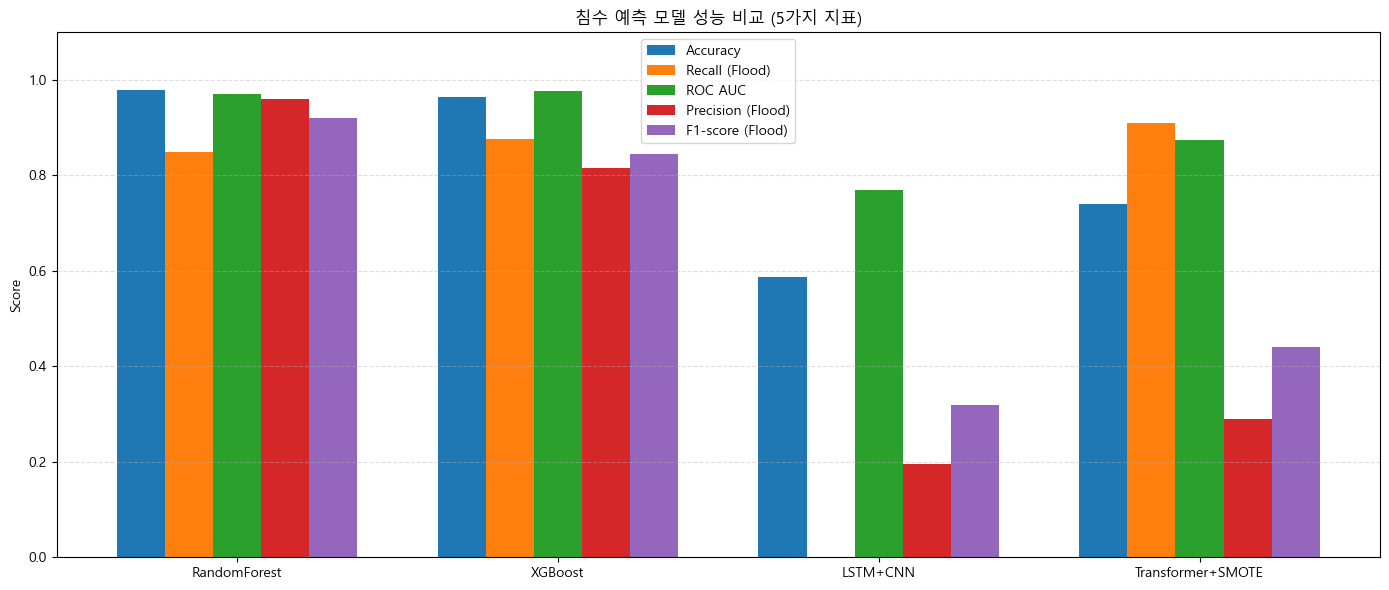

In [11]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 성능 지표
accuracy =     [0.980, 0.964, 0.587, 0.740]
recall =       [0.850, 0.876, 0.000, 0.910]   # 침수 Recall
roc_auc =      [0.970, 0.977, 0.769, 0.874]
precision =    [0.960, 0.816, 0.196, 0.290]   # 침수 Precision
f1_score =     [0.920, 0.845, 0.320, 0.440]   # 침수 F1-score

metrics = [accuracy, recall, roc_auc, precision, f1_score]
labels = ["Accuracy", "Recall (Flood)", "ROC AUC", "Precision (Flood)", "F1-score (Flood)"]

x = range(len(models))
bar_width = 0.15

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.bar([p + i * bar_width for p in x], metric, width=bar_width, label=labels[i])

plt.xticks([p + 2 * bar_width for p in x], models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("침수 예측 모델 성능 비교 (5가지 지표)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

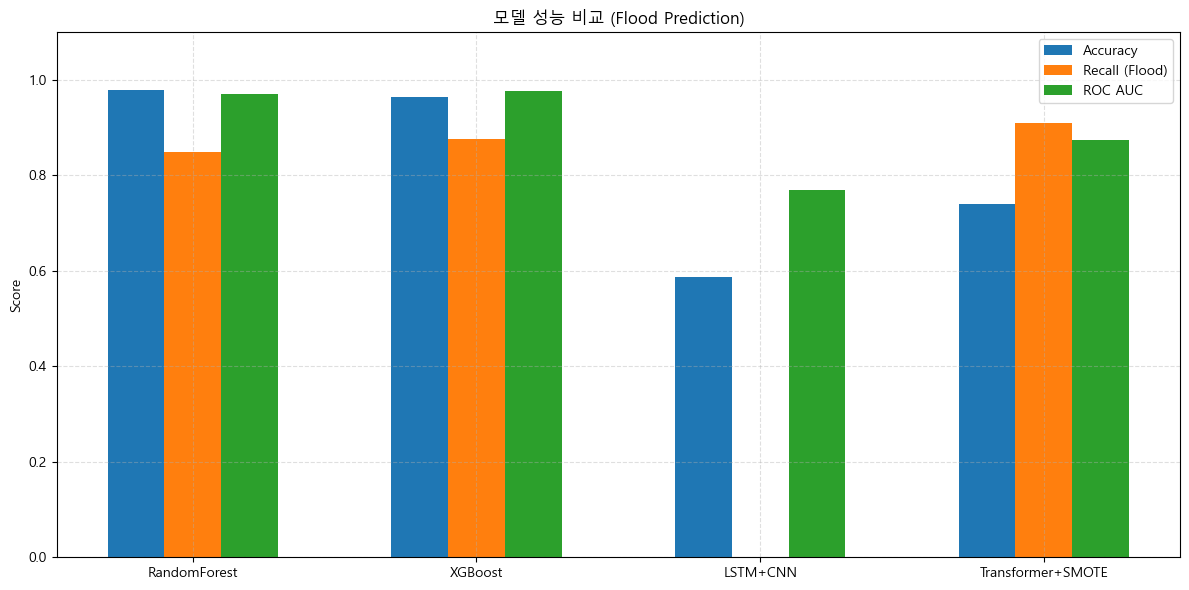

In [10]:
import matplotlib.pyplot as plt

# 모델 이름
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer+SMOTE"]

# 각 모델의 성능 지표
accuracy =     [0.980,     0.964,      0.587,         0.740]
recall_flood = [0.850,     0.876,      0.000,         0.910]  # 침수 클래스 recall
roc_auc =      [0.970,     0.977,      0.769,         0.874]

x = range(len(models))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracy, width=0.2, label='Accuracy', align='center')
plt.bar([i + 0.2 for i in x], recall_flood, width=0.2, label='Recall (Flood)', align='center')
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label='ROC AUC', align='center')

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.title("모델 성능 비교 (Flood Prediction)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# LSTM+CNN

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# 데이터 로딩
df = pd.read_csv("asos_seoul_daily_enriched.csv")

# 필요 컬럼만 선택
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs']
target = 'flood_risk'

# 결측치 제거
df = df.dropna(subset=features + [target])

# 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df[target].values

# 슬라이딩 윈도우 함수 정의
def create_sequences(X, y, window_size=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, window_size=7)

# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# LSTM + CNN 모델 구성 및 학습
model = Sequential()
model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/20
71/71 [==============================] - 6s 12ms/step - loss: 0.4055 - accuracy: 0.8890 - val_loss: 0.3389 - val_accuracy: 0.8824
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3135 - accuracy: 0.8894 - val_loss: 0.3086 - val_accuracy: 0.8824
Epoch 3/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3060 - accuracy: 0.8894 - val_loss: 0.3120 - val_accuracy: 0.8824
Epoch 4/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3062 - accuracy: 0.8894 - val_loss: 0.3080 - val_accuracy: 0.8824
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3068 - accuracy: 0.8894 - val_loss: 0.3123 - val_accuracy: 0.8824
Epoch 6/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3062 - accuracy: 0.8894 - val_loss: 0.3098 - val_accuracy: 0.8824
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 0.3037 - accuracy: 0.8894 - val_loss: 0.3096 - val_accuracy: 0.8824


# 평가 및 저장

In [4]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

22/22 [==============================] - 0s 4ms/step


In [5]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

Confusion Matrix:
 [[623   0]
 [ 78   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       623
           1       0.00      0.00      0.00        78

    accuracy                           0.89       701
   macro avg       0.44      0.50      0.47       701
weighted avg       0.79      0.89      0.84       701


ROC AUC Score: 0.7929373996789727


# 모델 저장

In [6]:
# 모델 저장
model.save("lstm_cnn_model.h5")
joblib.dump(scaler, "lstm_cnn_scaler.pkl")

['lstm_cnn_scaler.pkl']

# 시각화 (ROC, PR Curve)

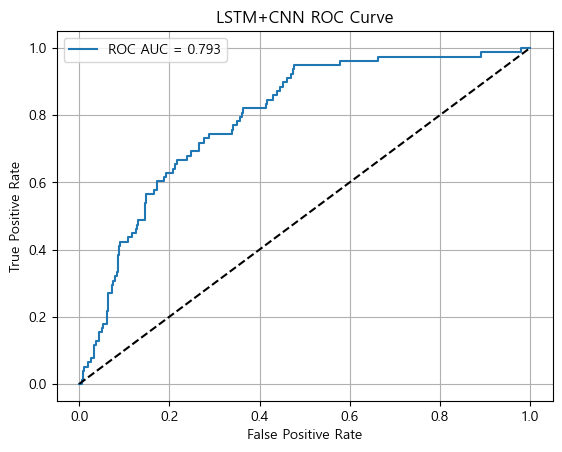

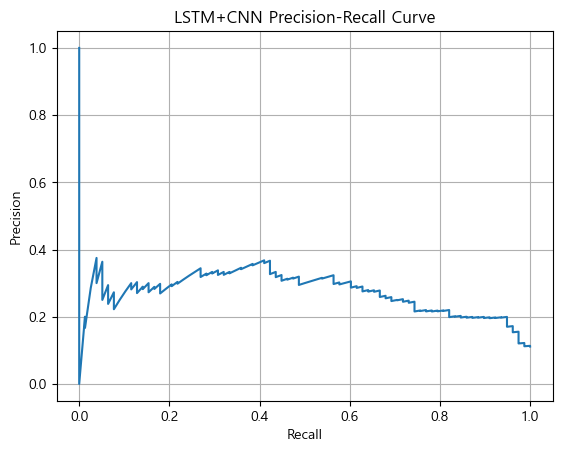

In [7]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM+CNN ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LSTM+CNN Precision-Recall Curve")
plt.grid()
plt.show()


# 성능 요약
```
Confusion Matrix	양성(침수)을 78건 중 0건 예측 → Recall=0.00
Precision=0	침수라고 예측한 것 중 실제로 맞은 게 없음
```

# 참고
## class_weight 먼저 적용하면 나아질수도 있으나 이전 시간&일별에서 해봐도 별 차이 없었음
```
참고 추가할 코드
from sklearn.utils import class_weight

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = dict(enumerate(class_weights))

# 모델 훈련 시 적용
model.fit(X_train, y_train, epochs=20, batch_size=32, 
          validation_split=0.2, 
          callbacks=[early_stop],
          class_weight=cw)
```